In [58]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import one_hot
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import difflib
import nltk
from sklearn.model_selection import train_test_split
nltk.download('punkt')
nltk.download('brown')
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stop = stopwords.words('english')
stop = set(stopwords.words('english')) - {'no', 'not','never',"don't",'never','nor'}
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob
from nltk import classify
from nltk import NaiveBayesClassifier

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/myleskornfeld/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     /Users/myleskornfeld/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/myleskornfeld/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/myleskornfeld/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/myleskornfeld/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [59]:
print(stop)

{'weren', 'were', 'other', "aren't", 't', 'herself', 'was', 'is', 're', 'wasn', 'such', 'what', 'where', "didn't", 'as', 'hasn', 'who', 'while', 'only', "couldn't", 'just', 'won', 'that', 'than', 'your', 'shan', 'to', 'yourselves', 'below', 'now', 'couldn', 'ours', 'or', 'through', 'above', 'have', 'off', "you've", 'once', 'each', 'with', 'its', 'hadn', 'up', 'few', "mustn't", 'own', 's', 'can', 'them', 'during', 'don', 'an', 'himself', 'but', 'am', 'theirs', "doesn't", 'has', 'hers', "should've", 'then', 'it', 'itself', 'themselves', 'because', 'after', 'into', 'how', 'against', 'will', 've', "that'll", "hadn't", 'd', "won't", 'which', 'from', 'when', "needn't", 'our', "isn't", "you'd", 'under', 'all', 'ourselves', 'didn', 'you', "wouldn't", 'so', 'ain', 'out', 'doing', 'until', 'any', 'she', 'did', 'be', 'by', 'on', 'll', 'y', 'of', 'haven', 'mightn', 'at', 'should', 'he', 'yours', 'doesn', 'this', 'having', 'these', 'we', 'if', "weren't", 'most', 'too', 'myself', 'his', 'isn', 'bein

In [60]:
df_train = pd.read_csv('../training.1600000.processed.noemoticon.csv',encoding='latin-1')
df_test = pd.read_csv('../testdata.manual.2009.06.14.csv',encoding='latin-1')
df_test = df_test[df_test['sentiment']!=2]

In [61]:
df_train[(df_train['text'].str.contains(r'no|not|never|didnt',regex=True))&(df_train['sentiment']==0)].count()

sentiment    217486
user_id      217486
date         217486
query        217486
user         217486
text         217486
dtype: int64

In [62]:
df_train[(df_train['text'].str.contains(r'no|not|never|didnt|nor',regex=True))&(df_train['sentiment']==2)].count()

sentiment    0
user_id      0
date         0
query        0
user         0
text         0
dtype: int64

In [126]:
df_concat = pd.concat([df_train,df_test],axis=0)
df_concat.head()

,sentiment,user_id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [63]:
df_train[(df_train['text'].str.contains(r'no|not|never|didnt',regex=True))&(df_train['sentiment']==4)].count()

sentiment    144569
user_id      144569
date         144569
query        144569
user         144569
text         144569
dtype: int64

In [132]:
df_concat['text'] = df_concat['text'].str.lower()
df_concat['text'] = df_concat['text'].apply(lambda x: ' '.join([word for word in x.split() if '@' not in word]))
df_concat['text'] = df_concat['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_concat['text'] = df_concat['text'].apply(lambda x: ' '.join([word for word in x.split() if 'http' not in word]))
df_concat['text'] = df_concat['text'].str.replace(r'[^\w\s]','',regex=True)
df_concat['sentiment'] = df_concat['sentiment'].replace(4,1)
df_concat.head()

,sentiment,user_id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww thats bummer shoulda got david carr third...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset cant update facebook texting might cry r...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go ...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no not behaving im mad cant see


In [133]:
df_concat.head().to_markdown()

'|    |   sentiment |    user_id | date                         | query    | user            | text                                                                       |\n|---:|------------:|-----------:|:-----------------------------|:---------|:----------------|:---------------------------------------------------------------------------|\n|  0 |           0 | 1467810369 | Mon Apr 06 22:19:45 PDT 2009 | NO_QUERY | _TheSpecialOne_ | awww thats bummer shoulda got david carr third day                         |\n|  1 |           0 | 1467810672 | Mon Apr 06 22:19:49 PDT 2009 | NO_QUERY | scotthamilton   | upset cant update facebook texting might cry result school today also blah |\n|  2 |           0 | 1467810917 | Mon Apr 06 22:19:53 PDT 2009 | NO_QUERY | mattycus        | dived many times ball managed save 50 rest go bounds                       |\n|  3 |           0 | 1467811184 | Mon Apr 06 22:19:57 PDT 2009 | NO_QUERY | ElleCTF         | whole body feels itchy like fire             

Because of the imbalance in the testing data, i will combine the testing adn training and then do an 80/20 split

In [134]:
df_neg = df_concat[df_concat['text'].str.contains(r'no|not|never|didnt|never',regex=True)]
df_neg = df_neg.reset_index()
df_neg.head().to_markdown()

'|    |   index |   sentiment |    user_id | date                         | query    | user            | text                                                           |\n|---:|--------:|------------:|-----------:|:-----------------------------|:---------|:----------------|:---------------------------------------------------------------|\n|  0 |       4 |           0 | 1467811193 | Mon Apr 06 22:19:57 PDT 2009 | NO_QUERY | Karoli          | no not behaving im mad cant see                                |\n|  1 |       5 |           0 | 1467811372 | Mon Apr 06 22:20:00 PDT 2009 | NO_QUERY | joy_wolf        | not whole crew                                                 |\n|  2 |       7 |           0 | 1467811594 | Mon Apr 06 22:20:03 PDT 2009 | NO_QUERY | coZZ            | hey long time no see yes rains bit bit lol im fine thanks hows |\n|  3 |       8 |           0 | 1467811795 | Mon Apr 06 22:20:05 PDT 2009 | NO_QUERY | 2Hood4Hollywood | nope                                         

In [66]:
df_neg['text'] = df_neg['text'].str.lower()
df_neg['text'] = df_neg['text'].apply(lambda x: ' '.join([word for word in x.split() if '@' not in word]))
df_neg['text'] = df_neg['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_neg['text'] = df_neg['text'].str.replace(r'[^\w\s]','',regex=True)
df_neg.head()

,index,sentiment,user_id,date,query,user,text
0,4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no not behaving all im mad here cant see there
1,5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,not whole crew
2,7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,hey long time no see yes rains bit only bit lo...
3,8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,nope
4,10,0,1467812416,Mon Apr 06 22:20:16 PDT 2009,NO_QUERY,erinx3leannexo,spring break plain city snowing


In [92]:
df_neg['sentiment'] = df_neg['sentiment'].replace(4,1)

<AxesSubplot:>

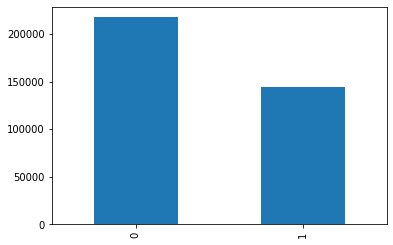

In [93]:
df_neg['sentiment'].value_counts(sort=False).plot.bar()

Remove outliers

count    362116.000000
mean          9.397431
std           4.068642
min           0.000000
25%           6.000000
50%           9.000000
75%          12.000000
max          29.000000
Name: text, dtype: float64

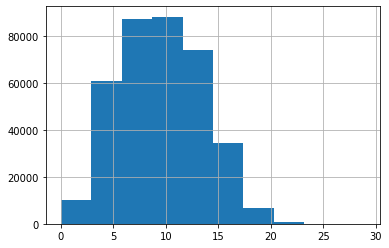

In [96]:
# df_neg['text'].str.split().apply(len).value_counts().head()
df_neg['text'].apply(lambda n: len(n.split())).hist()
df_neg['text'].apply(lambda n: len(n.split())).describe()

In [97]:
#df_neg = df_neg[df_neg['text'].str.count(" ") >= 2]

In [98]:
vocab_size = 5000
max_length = df_neg['text'].apply(lambda n: len(n.split())).max()

myTokenizer = Tokenizer(num_words=vocab_size)
myTokenizer.fit_on_texts(df_concat['text'])
#print(myTokenizer.word_index)
sequences = myTokenizer.texts_to_sequences(df_neg['text'])
padded = pad_sequences(sequences, maxlen=max_length, padding="post")
#padded = pad_sequences(sequences, maxlen=20, padding="post")

len(padded)

362116

In [100]:
df_neg.head()

,index,sentiment,user_id,date,query,user,text
0,4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no not behaving all im mad here cant see there
1,5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,not whole crew
2,7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,hey long time no see yes rains bit only bit lo...
3,8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,nope
4,10,0,1467812416,Mon Apr 06 22:20:16 PDT 2009,NO_QUERY,erinx3leannexo,spring break plain city snowing


In [101]:
df_final = df_neg.join(pd.DataFrame(padded))

In [102]:
df_final.head()

,index,sentiment,user_id,date,query,user,text,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
0,4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no not behaving all im mad here cant see there,36,24,32,58,617,91,171,68,86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,not whole crew,24,450,2247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,hey long time no see yes rains bit only bit lo...,157,172,50,36,68,160,2765,131,115,131,49,58,549,82,1786,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,nope,827,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,10,0,1467812416,Mon Apr 06 22:20:16 PDT 2009,NO_QUERY,erinx3leannexo,spring break plain city snowing,1689,546,3268,628,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [103]:
df_data = df_final.drop(['index','user_id','date','query','user','text'],axis=1)
df_data.head()

,sentiment,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
0,0,36,24,32,58,617,91,171,68,86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,24,450,2247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,157,172,50,36,68,160,2765,131,115,131,49,58,549,82,1786,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,827,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1689,546,3268,628,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [119]:
df_sample = df_data.sample(frac=0.1,random_state=42)
y = df_sample['sentiment']
X = df_sample.drop('sentiment',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [111]:
def determine_lr(model, name, guess):
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: guess * 10**(epoch/15))
    optimizer = tf.keras.optimizers.SGD(lr=guess, momentum=0.9) #Stochastic gradient descent optimizer
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=70, callbacks = lr_schedule)
    plt.semilogx(history.history["lr"], history.history["loss"])
    plt.xlabel("Learning Rate (log)")
    plt.ylabel("Loss")
    plt.title("Learning Rate Determination "+name)
    plt.show()

#Produces a summary of the model and returns the history
def run_model(model, lrate):
    optimizer = tf.keras.optimizers.SGD(lr=lrate, momentum=0.9) #Stochastic gradient descent optimizer
    model.compile(optimizer = 'adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    print('data is compiled')
    history = model.fit(x=X_train, y=y_train, epochs=epoch_num, validation_data=(X_test, y_test))
    model.summary()
    return history

Epoch 1/70


2023-01-22 16:49:09.159656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 16:49:09.413090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 16:49:09.424800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 16:49:09.758632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 16:49:09.773181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


453/453 [==============================] - 18s 35ms/step - loss: 0.6627 - accuracy: 0.6007 - lr: 1.0000e-09
Epoch 2/70
453/453 [==============================] - 14s 30ms/step - loss: 0.6627 - accuracy: 0.6007 - lr: 1.1659e-09
Epoch 3/70
453/453 [==============================] - 14s 30ms/step - loss: 0.6627 - accuracy: 0.6007 - lr: 1.3594e-09
Epoch 4/70
453/453 [==============================] - 14s 30ms/step - loss: 0.6627 - accuracy: 0.6007 - lr: 1.5849e-09
Epoch 5/70
453/453 [==============================] - 14s 30ms/step - loss: 0.6627 - accuracy: 0.6007 - lr: 1.8478e-09
Epoch 6/70
453/453 [==============================] - 14s 30ms/step - loss: 0.6627 - accuracy: 0.6007 - lr: 2.1544e-09
Epoch 7/70
453/453 [==============================] - 14s 30ms/step - loss: 0.6627 - accuracy: 0.6007 - lr: 2.5119e-09
Epoch 8/70
453/453 [==============================] - 14s 30ms/step - loss: 0.6627 - accuracy: 0.6007 - lr: 2.9286e-09
Epoch 9/70
453/453 [==============================] - 14s 3

453/453 [==============================] - 14s 30ms/step - loss: 0.5682 - accuracy: 0.7198 - lr: 3.4145e-05
Epoch 70/70
453/453 [==============================] - 14s 30ms/step - loss: 0.5550 - accuracy: 0.7283 - lr: 3.9811e-05


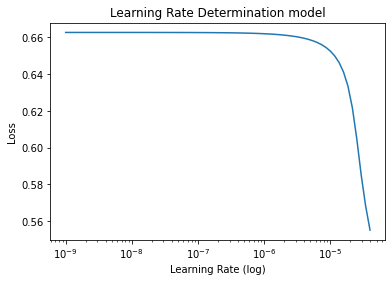

In [112]:
determine_lr(model, "model", 1e-9)

Epoch 1/70


2023-01-22 17:08:42.349139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 17:08:42.589304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 17:08:42.601268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 17:08:42.953529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 17:08:42.968546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


453/453 [==============================] - 18s 37ms/step - loss: 0.5447 - accuracy: 0.7395 - lr: 1.0000e-05
Epoch 2/70
453/453 [==============================] - 14s 32ms/step - loss: 0.5423 - accuracy: 0.7406 - lr: 1.1659e-05
Epoch 3/70
453/453 [==============================] - 14s 31ms/step - loss: 0.5394 - accuracy: 0.7414 - lr: 1.3594e-05
Epoch 4/70
453/453 [==============================] - 14s 31ms/step - loss: 0.5361 - accuracy: 0.7449 - lr: 1.5849e-05
Epoch 5/70
453/453 [==============================] - 14s 31ms/step - loss: 0.5326 - accuracy: 0.7455 - lr: 1.8478e-05
Epoch 6/70
453/453 [==============================] - 14s 31ms/step - loss: 0.5286 - accuracy: 0.7487 - lr: 2.1544e-05
Epoch 7/70
453/453 [==============================] - 14s 31ms/step - loss: 0.5239 - accuracy: 0.7503 - lr: 2.5119e-05
Epoch 8/70
453/453 [==============================] - 14s 31ms/step - loss: 0.5178 - accuracy: 0.7556 - lr: 2.9286e-05
Epoch 9/70
453/453 [==============================] - 14s 3

453/453 [==============================] - 13s 29ms/step - loss: 0.6806 - accuracy: 0.5918 - lr: 0.3981


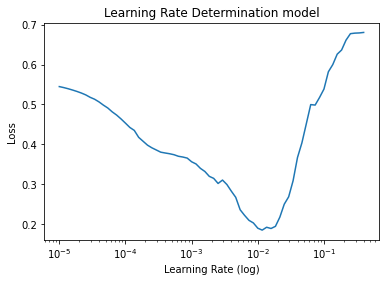

In [113]:
determine_lr(model, "model", 1e-5)

In [117]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    #tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout = 0.3, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

num_epochs = 10
optimizer = tf.keras.optimizers.SGD(lr=0.0158, momentum=0.9) #Stochastic gradient descent optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs = num_epochs, validation_data=(X_test, y_test))


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 29, 16)            80000     
                                                                 
 bidirectional_3 (Bidirectio  (None, 29, 32)           4224      
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 6)                 198       
                                                                 
 dense_13 (Dense)            (None, 1)                 7         
                                                                 
Total params: 90,701
Trainable params: 90,701
Non-tra

2023-01-22 17:37:42.574722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 17:37:43.083292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 17:37:43.093650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 17:37:43.303524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 17:37:43.316266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 17:37:43.775307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 17:37:43.790250: I tensorflow/core/grappler/optimizers/cust

453/453 [==============================] - ETA: 0s - loss: 0.6214 - accuracy: 0.6536

2023-01-22 17:38:15.011269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 17:38:15.160968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 17:38:15.168004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 17:38:15.354060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 17:38:15.361398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


453/453 [==============================] - 38s 76ms/step - loss: 0.6214 - accuracy: 0.6536 - val_loss: 0.5788 - val_accuracy: 0.7035
Epoch 2/10
453/453 [==============================] - 29s 64ms/step - loss: 0.5126 - accuracy: 0.7522 - val_loss: 0.5570 - val_accuracy: 0.7156
Epoch 3/10
453/453 [==============================] - 29s 64ms/step - loss: 0.4668 - accuracy: 0.7856 - val_loss: 0.5755 - val_accuracy: 0.7189
Epoch 4/10
453/453 [==============================] - 28s 63ms/step - loss: 0.4343 - accuracy: 0.8100 - val_loss: 0.5882 - val_accuracy: 0.7187
Epoch 5/10
453/453 [==============================] - 28s 62ms/step - loss: 0.4142 - accuracy: 0.8184 - val_loss: 0.5955 - val_accuracy: 0.7087
Epoch 6/10
453/453 [==============================] - 29s 64ms/step - loss: 0.3910 - accuracy: 0.8335 - val_loss: 0.6164 - val_accuracy: 0.7057
Epoch 7/10
453/453 [==============================] - 29s 64ms/step - loss: 0.3707 - accuracy: 0.8459 - val_loss: 0.6278 - val_accuracy: 0.7035
Epo

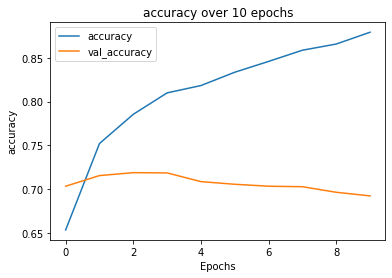

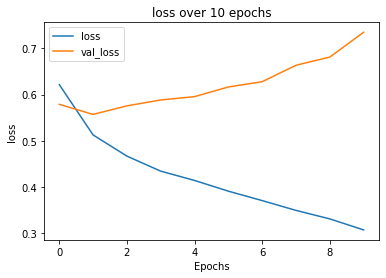

In [118]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.title(string + " over " + str(num_epochs) + " epochs")
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

gridsearch on vocab size, config of layers, embedding dimensions, learning rate, embedding initializers, regularizers, constraints<br>
figure out what the ball park is with vocab size first, then finetune with gridsearch

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 29, 16)            80000     
                                                                 
 bidirectional_7 (Bidirectio  (None, 29, 32)           4224      
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_16 (Dense)            (None, 6)                 198       
                                                                 
 dense_17 (Dense)            (None, 1)                 7         
                                                                 
Total params: 90,701
Trainable params: 90,701
Non-tra

2023-01-22 17:44:36.046827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 17:44:36.528726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 17:44:36.538561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 17:44:36.743138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 17:44:36.753222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 17:44:37.223816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 17:44:37.238482: I tensorflow/core/grappler/optimizers/cust

906/906 [==============================] - ETA: 0s - loss: 0.5904 - accuracy: 0.6849

2023-01-22 17:45:34.006032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 17:45:34.163727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 17:45:34.171056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 17:45:34.366134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 17:45:34.373384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


906/906 [==============================] - 66s 69ms/step - loss: 0.5904 - accuracy: 0.6849 - val_loss: 0.5603 - val_accuracy: 0.7094
Epoch 2/10
906/906 [==============================] - 56s 62ms/step - loss: 0.5067 - accuracy: 0.7576 - val_loss: 0.5619 - val_accuracy: 0.7084
Epoch 3/10
906/906 [==============================] - 59s 65ms/step - loss: 0.4813 - accuracy: 0.7756 - val_loss: 0.5817 - val_accuracy: 0.7073
Epoch 4/10
906/906 [==============================] - 59s 65ms/step - loss: 0.4613 - accuracy: 0.7867 - val_loss: 0.5770 - val_accuracy: 0.7070
Epoch 5/10
906/906 [==============================] - 57s 63ms/step - loss: 0.4437 - accuracy: 0.8001 - val_loss: 0.6062 - val_accuracy: 0.7055
Epoch 6/10
906/906 [==============================] - 55s 60ms/step - loss: 0.4255 - accuracy: 0.8096 - val_loss: 0.6113 - val_accuracy: 0.7068
Epoch 7/10
906/906 [==============================] - 55s 60ms/step - loss: 0.4077 - accuracy: 0.8187 - val_loss: 0.6347 - val_accuracy: 0.7092
Epo

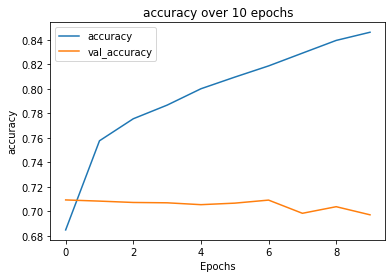

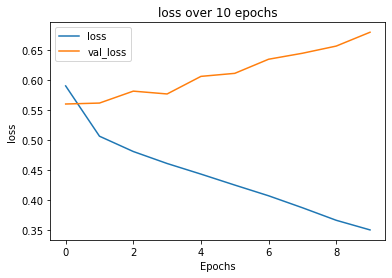

In [121]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    #tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout = 0.3, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

num_epochs = 10
optimizer = tf.keras.optimizers.SGD(lr=0.0158, momentum=0.9) #Stochastic gradient descent optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs = num_epochs, validation_data=(X_test, y_test))

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 29, 16)            80000     
                                                                 
 bidirectional_9 (Bidirectio  (None, 29, 32)           4224      
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 32)               6272      
 onal)                                                           
                                                                 
 dense_18 (Dense)            (None, 6)                 198       
                                                                 
 dense_19 (Dense)            (None, 1)                 7         
                                                                 
Total params: 90,701
Trainable params: 90,701
Non-tra

2023-01-22 18:00:31.989765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 18:00:32.512491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 18:00:32.522358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 18:00:32.735933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 18:00:32.745944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 18:00:33.208720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 18:00:33.223609: I tensorflow/core/grappler/optimizers/cust

906/906 [==============================] - ETA: 0s - loss: 0.5876 - accuracy: 0.6883

2023-01-22 18:01:31.778188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 18:01:31.953829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 18:01:31.962365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 18:01:32.173359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 18:01:32.182082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


906/906 [==============================] - 69s 72ms/step - loss: 0.5876 - accuracy: 0.6883 - val_loss: 0.5602 - val_accuracy: 0.7098
Epoch 2/10
906/906 [==============================] - 56s 62ms/step - loss: 0.5067 - accuracy: 0.7562 - val_loss: 0.5587 - val_accuracy: 0.7132
Epoch 3/10
906/906 [==============================] - 54s 59ms/step - loss: 0.4765 - accuracy: 0.7756 - val_loss: 0.5793 - val_accuracy: 0.7101
Epoch 4/10
906/906 [==============================] - 55s 61ms/step - loss: 0.4517 - accuracy: 0.7899 - val_loss: 0.5722 - val_accuracy: 0.7126
Epoch 5/10
906/906 [==============================] - 55s 61ms/step - loss: 0.4272 - accuracy: 0.8017 - val_loss: 0.6208 - val_accuracy: 0.7152
Epoch 6/10
906/906 [==============================] - 54s 60ms/step - loss: 0.4052 - accuracy: 0.8128 - val_loss: 0.6181 - val_accuracy: 0.7094
Epoch 7/10
906/906 [==============================] - 54s 60ms/step - loss: 0.3854 - accuracy: 0.8215 - val_loss: 0.6560 - val_accuracy: 0.7047
Epo

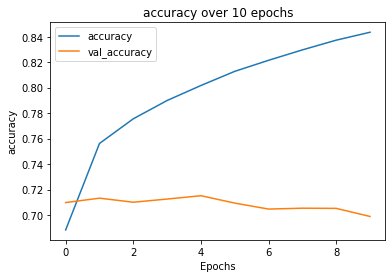

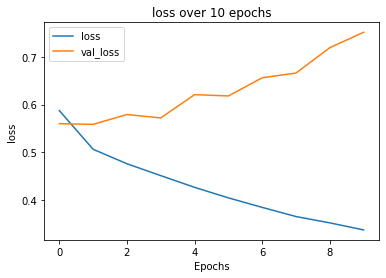

In [122]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    #tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout = 0.3, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

num_epochs = 10
optimizer = tf.keras.optimizers.SGD(lr=0.0158) #Stochastic gradient descent optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs = num_epochs, validation_data=(X_test, y_test))

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 29, 16)            80000     
                                                                 
 bidirectional_11 (Bidirecti  (None, 29, 32)           4224      
 onal)                                                           
                                                                 
 bidirectional_12 (Bidirecti  (None, 32)               6272      
 onal)                                                           
                                                                 
 dense_20 (Dense)            (None, 6)                 198       
                                                                 
 dense_21 (Dense)            (None, 1)                 7         
                                                                 
Total params: 90,701
Trainable params: 90,701
Non-tra

2023-01-22 18:10:59.965296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 18:11:00.717937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 18:11:00.732399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 18:11:00.960473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 18:11:00.971566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 18:11:01.545418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 18:11:01.560271: I tensorflow/core/grappler/optimizers/cust

906/906 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.6830

2023-01-22 18:12:00.071548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 18:12:00.251174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 18:12:00.258851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 18:12:00.470318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-22 18:12:00.477767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


906/906 [==============================] - 71s 72ms/step - loss: 0.6903 - accuracy: 0.6830 - val_loss: 0.5950 - val_accuracy: 0.7072
Epoch 2/10
906/906 [==============================] - 56s 62ms/step - loss: 0.5465 - accuracy: 0.7516 - val_loss: 0.5897 - val_accuracy: 0.7085
Epoch 3/10
906/906 [==============================] - 56s 62ms/step - loss: 0.5160 - accuracy: 0.7720 - val_loss: 0.5895 - val_accuracy: 0.7113
Epoch 4/10
906/906 [==============================] - 57s 62ms/step - loss: 0.4989 - accuracy: 0.7849 - val_loss: 0.6006 - val_accuracy: 0.7098
Epoch 5/10
906/906 [==============================] - 57s 62ms/step - loss: 0.4841 - accuracy: 0.7931 - val_loss: 0.6137 - val_accuracy: 0.7088
Epoch 6/10
906/906 [==============================] - 55s 61ms/step - loss: 0.4698 - accuracy: 0.8012 - val_loss: 0.6027 - val_accuracy: 0.7045
Epoch 7/10
906/906 [==============================] - 55s 60ms/step - loss: 0.4577 - accuracy: 0.8090 - val_loss: 0.6272 - val_accuracy: 0.7058
Epo

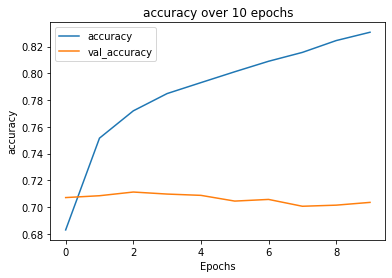

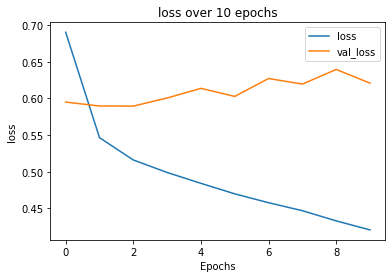

In [123]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    #tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout = 0.3, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6, activation='relu',kernel_regularizer='l1_l2'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

num_epochs = 10
optimizer = tf.keras.optimizers.SGD(lr=0.0158, momentum=0.9) #Stochastic gradient descent optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs = num_epochs, validation_data=(X_test, y_test))

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")